In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras_self_attention import SeqSelfAttention


import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
precipitation_df = pd.read_csv('/content/drive/MyDrive/Data_Kaggle/pune_1965_to_2002.csv')

precipitation_df.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1,1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
2,1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
3,1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
4,1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951


In [3]:
precipitation_df.set_index('Year', inplace=True)

precipitation_df.head(5)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951


In [4]:
precipitation_df = precipitation_df.transpose()

precipitation_df.head(12)

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.029,0.905,0.248,0.318,0.248,0.070,0.000,0.000,0.000,0.000,...,0.000,0.879,0.695,0.016,1.284,0.008,0.000,0.000,0.147,0.231
Feb,0.069,0.000,3.390,3.035,2.524,0.000,0.000,0.029,2.969,0.000,...,0.078,0.325,0.000,2.779,0.000,2.671,1.431,0.170,0.000,0.911
Mar,0.000,0.000,1.320,1.704,0.334,0.001,0.000,0.000,0.234,6.427,...,1.211,2.415,1.770,0.087,0.747,0.073,0.000,0.000,2.178,0.388
Apr,21.667,2.981,13.482,23.307,4.569,16.218,0.812,5.982,3.925,16.864,...,2.062,16.823,25.949,6.318,23.912,0.377,0.642,1.193,1.528,53.266
May,17.859,63.008,11.116,7.441,6.213,68.036,57.691,19.101,14.978,51.209,...,3.248,33.378,23.964,5.134,4.664,15.717,35.828,26.237,7.860,18.430
Jun,102.111,94.088,251.314,179.872,393.682,300.546,297.187,132.413,304.484,148.697,...,234.068,749.030,163.515,453.607,673.831,238.609,415.471,371.328,247.982,509.145
Jul,606.071,481.942,780.006,379.354,678.354,330.502,122.195,338.484,696.024,405.359,...,450.088,707.986,501.461,558.586,422.913,590.663,277.137,265.417,279.547,84.936
Aug,402.521,59.386,181.069,171.979,397.335,283.476,372.693,68.741,256.932,319.651,...,150.278,230.898,114.206,212.489,541.579,362.357,98.616,220.814,189.404,257.205
Sep,69.511,150.624,183.757,219.884,205.413,158.640,286.056,120.415,183.206,288.533,...,101.928,115.509,288.262,203.642,60.477,243.444,225.962,147.196,158.025,78.269
Oct,5.249,1.308,50.404,73.997,24.014,115.758,39.424,1.078,101.805,188.876,...,225.904,116.348,84.359,176.471,31.050,96.324,180.300,38.246,135.518,21.486


In [5]:
dates = pd.date_range(start='1965-01', freq='MS', periods=len(precipitation_df.columns)*12)

print(dates)

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')


Text(0.5, 1.0, 'Month vs Precipitation (1965-2002)')

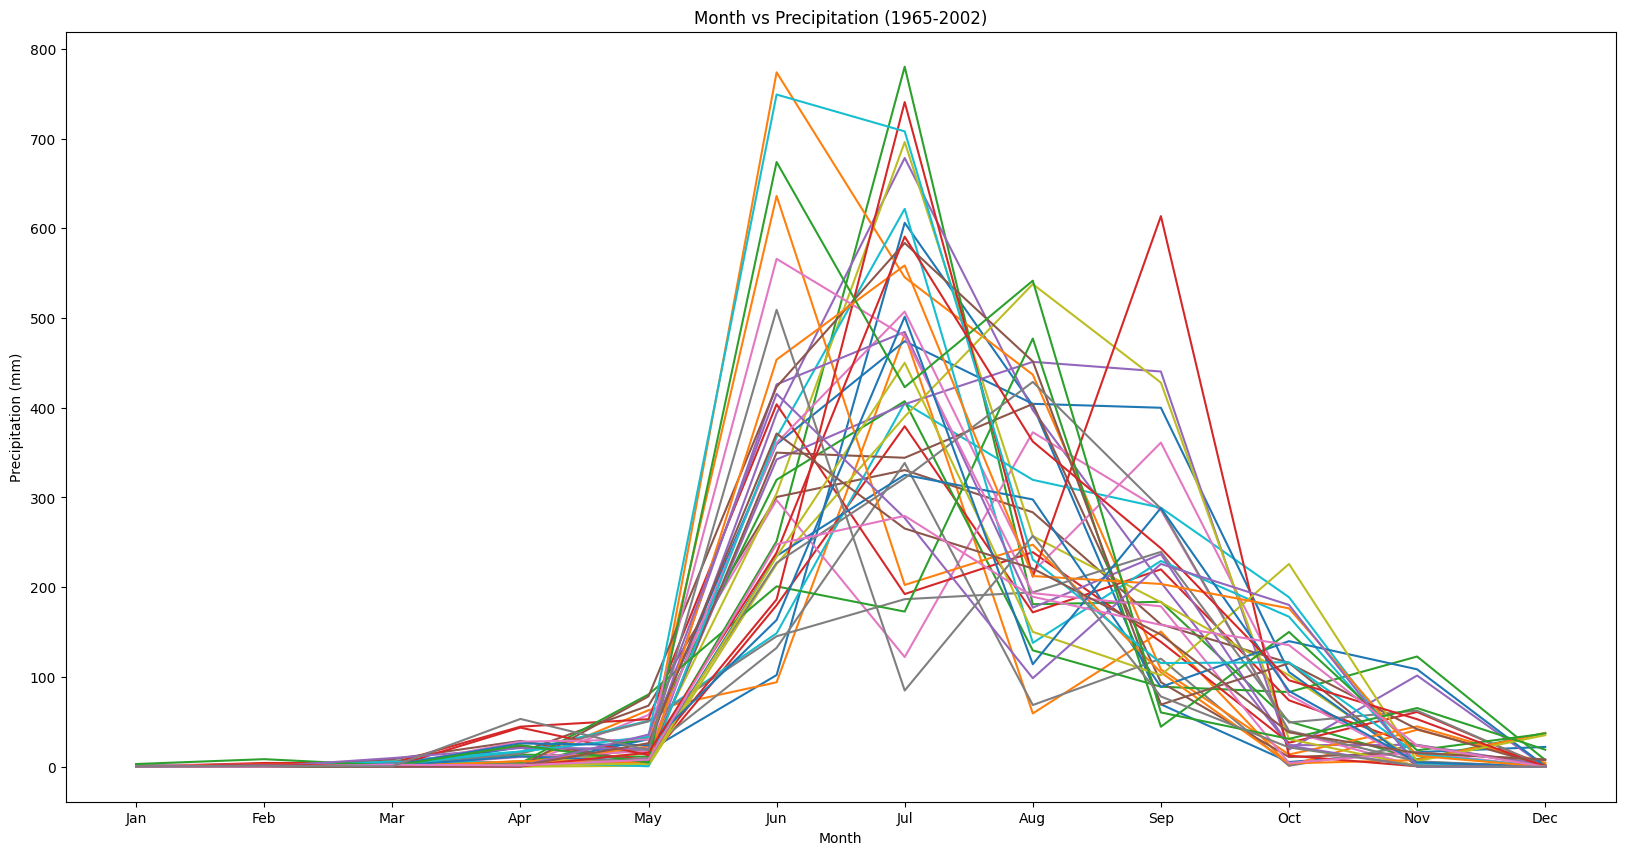

In [6]:
plt.figure(figsize=(20,10))
plt.plot(precipitation_df)
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.title('Month vs Precipitation (1965-2002)')

In [7]:
rainfall_data_matrix_df = (
    precipitation_df.transpose()
    .stack()
    .reset_index()
)


print(rainfall_data_matrix_df.columns)

rainfall_data_matrix_df.columns = ['Year', 'Month', 'Precipitation']


rainfall_data_matrix_df['Year-Month'] = rainfall_data_matrix_df['Year'].astype(str) + '-' + rainfall_data_matrix_df['Month']

rainfall_data_matrix_df = rainfall_data_matrix_df[['Year-Month', 'Precipitation']]

Index(['Year', 'level_1', 0], dtype='object')


In [8]:
rainfall_data_matrix_df.head(25)

,Year-Month,Precipitation
0,1965-Jan,0.029
1,1965-Feb,0.069
2,1965-Mar,0.000
3,1965-Apr,21.667
4,1965-May,17.859
5,1965-Jun,102.111
6,1965-Jul,606.071
7,1965-Aug,402.521
8,1965-Sep,69.511
9,1965-Oct,5.249


In [9]:
rainfall_data_matrix_df['Year-Month'] = pd.to_datetime(rainfall_data_matrix_df['Year-Month'], format='%Y-%b')

rainfall_data_matrix_df.head(12)

,Year-Month,Precipitation
0,1965-01-01,0.029
1,1965-02-01,0.069
2,1965-03-01,0.000
3,1965-04-01,21.667
4,1965-05-01,17.859
5,1965-06-01,102.111
6,1965-07-01,606.071
7,1965-08-01,402.521
8,1965-09-01,69.511
9,1965-10-01,5.249


In [10]:
rainfall_data_matrix_df.set_index('Year-Month', inplace=True)

rainfall_data_matrix_df.head(12)

,Precipitation
Year-Month,
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859
1965-06-01,102.111
1965-07-01,606.071
1965-08-01,402.521
1965-09-01,69.511


In [11]:
train_data = rainfall_data_matrix_df[:'1994']
test_data = rainfall_data_matrix_df['1995':]

In [12]:
train_data.head(5)

,Precipitation
Year-Month,
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


Text(0.5, 1.0, 'Precipitation in mm')

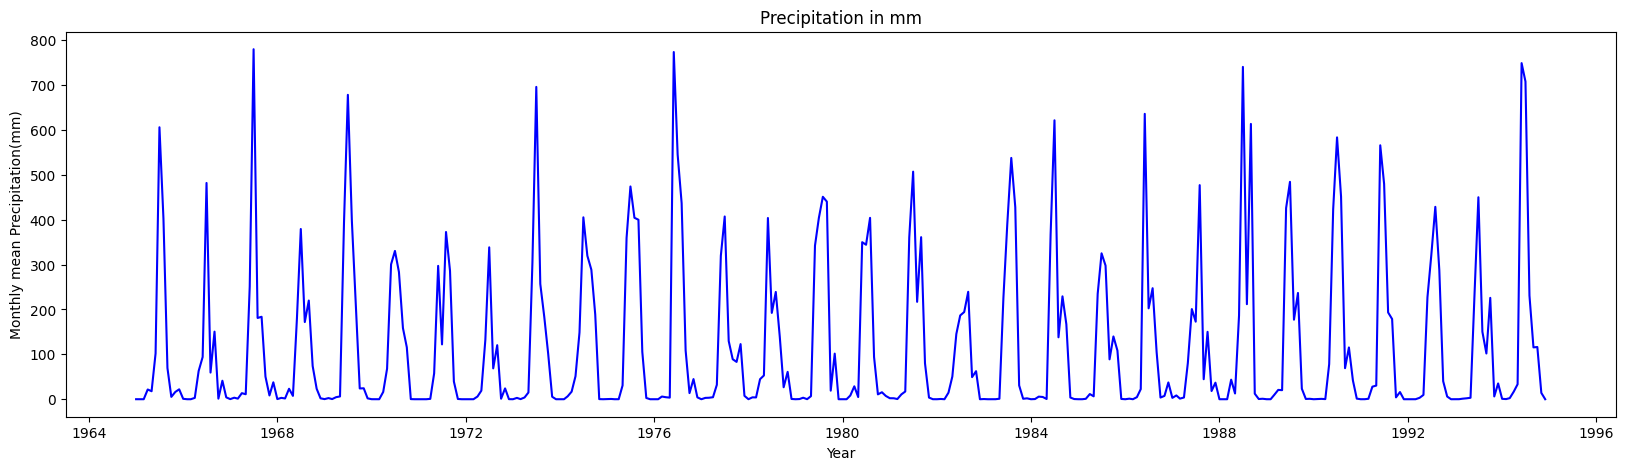

In [13]:
plt.figure(figsize=(20,5))
plt.plot(train_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Precipitation in mm')

#LSTM

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

In [15]:
train_data[:5]

array([[3.71792012e-05],
       [8.84608580e-05],
       [0.00000000e+00],
       [2.77779915e-02],
       [2.28959777e-02]])

In [16]:
scaler.inverse_transform(train_data[:5])

array([[ 0.0250525 ],
       [ 0.05960767],
       [ 0.        ],
       [18.71767176],
       [15.42801957]])

In [17]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (360, 1)
Shape of test data: (96, 1)


In [18]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [19]:
look_back = 3

train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

In [20]:
print("Shape of train input: " + str(train_X.shape))
print("Shape of train labels: " + str(train_Y.shape))
print("Shape of test input: " + str(test_X.shape))
print("Shape of test labels: " + str(test_Y.shape))

Shape of train input: (356, 3)
Shape of train labels: (356,)
Shape of test input: (92, 3)
Shape of test labels: (92,)


In [21]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [22]:
print("Shape of train input: " + str(train_X.shape))
print("Shape of train labels: " + str(train_Y.shape))
print("Shape of test input: " + str(test_X.shape))
print("Shape of test labels: " + str(test_Y.shape))

Shape of train input: (356, 1, 3)
Shape of train labels: (356,)
Shape of test input: (92, 1, 3)
Shape of test labels: (92,)


In [23]:
pip install keras-self-attention


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=c535404c31ac70b63358855b01e3c47de70e78d0b465b309ce7b0eae97b513d9
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [24]:


model = Sequential()
model.add(LSTM(4, return_sequences=True, input_shape=(1, look_back)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 4)                │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ seq_self_attention                   │ (None, 1, 4)                │             321 │
│ (SeqSelfAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 1)                │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 454 (1.77 KB)

 Trainable params: 454 (1.77 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
356/356 - 10s - 29ms/step - loss: 0.0511
Epoch 2/100
356/356 - 2s - 5ms/step - loss: 0.0420
Epoch 3/100
356/356 - 3s - 9ms/step - loss: 0.0389
Epoch 4/100
356/356 - 4s - 11ms/step - loss: 0.0365
Epoch 5/100
356/356 - 4s - 11ms/step - loss: 0.0357
Epoch 6/100
356/356 - 2s - 5ms/step - loss: 0.0349
Epoch 7/100
356/356 - 2s - 6ms/step - loss: 0.0345
Epoch 8/100
356/356 - 2s - 5ms/step - loss: 0.0341
Epoch 9/100
356/356 - 2s - 7ms/step - loss: 0.0340
Epoch 10/100
356/356 - 2s - 5ms/step - loss: 0.0338
Epoch 11/100
356/356 - 3s - 10ms/step - loss: 0.0336
Epoch 12/100
356/356 - 1s - 3ms/step - loss: 0.0333
Epoch 13/100
356/356 - 1s - 2ms/step - loss: 0.0331
Epoch 14/100
356/356 - 2s - 6ms/step - loss: 0.0329
Epoch 15/100
356/356 - 3s - 8ms/step - loss: 0.0328
Epoch 16/100
356/356 - 2s - 6ms/step - loss: 0.0325
Epoch 17/100
356/356 - 2s - 6ms/step - loss: 0.0324
Epoch 18/100
356/356 - 2s - 6ms/step - loss: 0.0322
Epoch 19/100
356/356 - 3s - 9ms/step - loss: 0.0320
Epoch 20/100
356

In [26]:
testPredict = model.predict(test_X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


In [27]:
testPredict[:5]

array([[[0.09719735]],

       [[0.17966795]],

       [[0.15790623]],

       [[0.45241687]],

       [[0.43842304]]], dtype=float32)

In [30]:
# Option 2: Using reshape() explicitly
testPredict = testPredict.reshape((92,1))

Text(0.5, 1.0, 'Precipitation Forecas Actual vs Predicted')

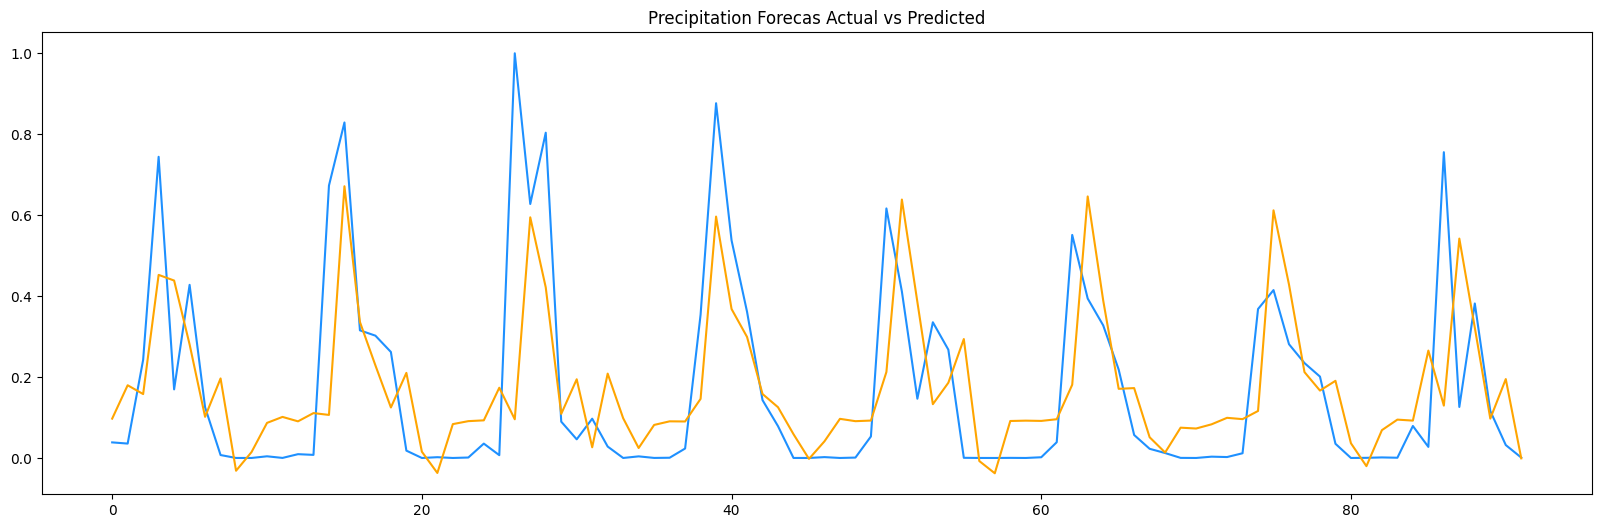

In [31]:
plt.figure(figsize=(20, 6))
plt.plot(test_Y,color='dodgerblue')
plt.plot(testPredict,color='orange')
plt.title('Precipitation Forecas Actual vs Predicted')